In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import *
from copy import copy, deepcopy

# from parameters import *



In [2]:
from models.geophysic_models.carbon_cycle_models import *
from models.geophysic_models.temperature_dynamic_model import *
from models.geophysic import *
from models.game_theory.benefit_function import *
from models.game import *

In [3]:
benef_coef = np.array([0,1])
damage_coef = np.array([0,0,1])
carbon_model = Carbon_DICE_2016R()
temperature_model = Temp_Discret_Geoffroy()


In [4]:
name = 'China'
benefit_function = polynome(benef_coef)
damage_function = polynome(damage_coef)
action_set = (0,30)
delta = 1.5
smc_player = geophysics(carbon_model, temperature_model)

In [5]:
def utility_one_shot(action : float, sum_other_actions : float, exogeneous_emission : float,
                            exogeneous_radiative_forcing : float) -> float:
        # carbon_model_copy = deepcopy(carbon_model)
        # temperature_model_copy = deepcopy(temperature_model)
        # smc_player = geophysics(carbon_model_copy, temperature_model_copy)
        temp = smc_player.five_years_atmospheric_temp(action + sum_other_actions, exogeneous_emission,
                            exogeneous_radiative_forcing)
        return benefit_function(action) - delta * damage_function(temp) 

In [6]:
def best_response_one_shot(sum_other_actions : float, exogeneous_emission : float,
                            exogeneous_radiative_forcing : float ) -> float:
    def response(x):
        return -utility_one_shot(x, sum_other_actions, exogeneous_emission, exogeneous_radiative_forcing)

    res = minimize_scalar(response, bounds=action_set, method='bounded', options={'xatol': 1e-05, 'maxiter': 1000, 'disp': 0})
    return res.x

In [7]:
sum_other = np.linspace(0,50,50)
responses = [best_response_one_shot(i, 2.6, 0.5) for i in sum_other]


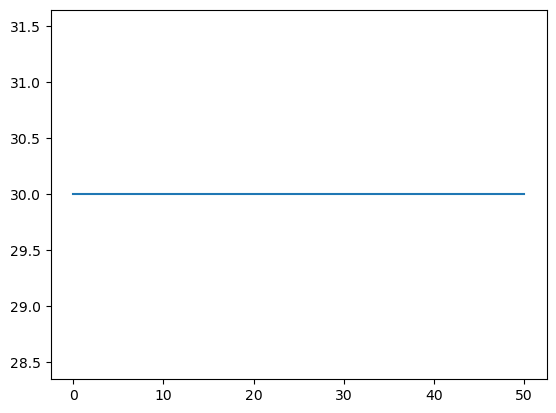

In [8]:
plt.plot(sum_other, responses)

plt.show() 

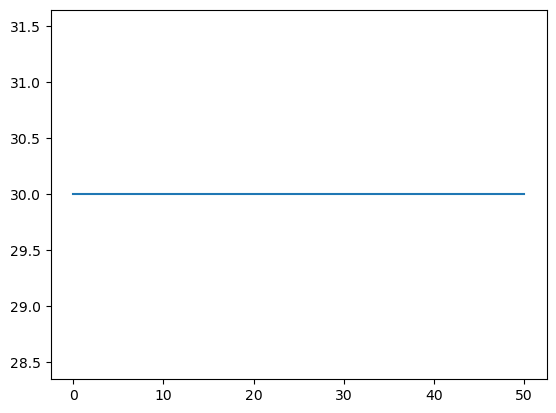

In [9]:
sum_other = np.linspace(0,50,50)
responses = [best_response_one_shot(i, 2.6, 0.5) for i in sum_other]
plt.plot(sum_other, responses)

plt.show()


In [10]:
action_set[1]

30

In [11]:

N = 2
action_set = (0.0,10.0)



benefit_function = polynome(benef_coef)
damage_function = polynome(damage_coef)
carbon_model = Carbon_DICE_2016R()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)
delta = 1.5
exogeneous_emission = 2.6
exogeneous_radiative_forcing = 0.5

list_players = [ player_class(name = 'player {}'.format(i), action_set = action_set, smc = deepcopy(smc), benefit_function = benefit_function, damage_function = damage_function, impact_factor_of_temperature = delta) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])
# list_actions = np.zeros_like([player.action_set[1] for player in list_players])


In [21]:

def best_response_dynamic_one_shot(array_actions : np.ndarray, list_players : list[player_class],
                                    exogeneous_emission : np.ndarray = EMISSION_TREE, exogeneous_radiative_forcing : np.ndarray = F_EX,
                                    step_criterion : int = 100, utility_criterion : float = 0.0001,
                                    diplay_progress : bool = False):
    #Const

    loss = 1000
    k = 0
    inital_action = deepcopy(array_actions)
    list_of_all_action = [inital_action]
    n = len(list_players)

    while (loss > utility_criterion) and (k < step_criterion):
        list_action = deepcopy(list_of_all_action[-1])
        if diplay_progress:
            print('k:', k)
            print('loss:', loss)
            print('list_of_all_action',     list_of_all_action)
        for indice in range(N):
            # print('BRD player ',indice)
            sum_other_actions = np.sum(list_action) - list_action[indice]

            list_action[indice] = round(list_players[indice].best_response_one_shot(sum_other_actions, exogeneous_emission, exogeneous_radiative_forcing), 2)

        k +=1
        loss = sum( [(list_action[indice] - list_of_all_action[-1][indice])**2 for indice in range(n)])
        
        list_of_all_action.append(list_action)

    if diplay_progress:
        if step_criterion <= k :
            print("Reach the step criterion.")
        if loss <= utility_criterion :
            print("Reach the utlity criterion in {} steps.".format(k))
    return list_of_all_action[-1]

In [13]:
best_response_dynamic_one_shot(list_actions, list_players, 5, 0.00 , diplay_progress=True)

k: 0
loss: 1000
list_of_all_action [array([10., 10.])]
Reach the utlity criterion in 1 steps.


array([10., 10.])

In [22]:

from numpy import zeros_like


def repeated_one_shot_game(list_players : list[player_class],
                            carbon_model : Linear_Carbon_Model, temperature_model : Linear_Temperature_Dynamic,
                            array_exogeneous_emission : np.ndarray, array_exogeneous_radiative_forcing : np.ndarray):
    smc_game = geophysics(carbon_model, temperature_model)
    n = len(list_players)
    list_actions_intial = np.array([player.action_set[1]/n for player in list_players])
    array_action = np.zeros((t, n)) 
    array_sum_action = np.zeros(t)
    list_temp = []
    list_temp_2 = []

    for time in range(t):
        array_action[time] = best_response_dynamic_one_shot(list_actions_intial, list_players, 5, 0.00 , diplay_progress=False)
        array_sum_action[time] = np.sum(array_action[time])
        for player in list_players:
            player.smc.initialize_carbon_model(deepcopy(smc_game.carbon_state))
            player.smc.initialize_temperature_dynamic(deepcopy(smc_game.temperature_state))
            # print(player.name)
            # print("before", player.smc.temperature_model.atmospheric_temperature(smc_game.temperature_state))
            player.update_smc(array_sum_action[time], array_exogeneous_emission[time], array_exogeneous_radiative_forcing[time])
            # print("after", player.smc.atmospheric_temp)
        smc_game.five_years_cycle_deep(array_sum_action[time], array_exogeneous_emission[time], array_exogeneous_radiative_forcing[time])

        list_temp.append(smc_game.atmospheric_temp)


    return array_action.T, array_sum_action, list_temp


def utility_function(action :np.ndarray, temperature :np.ndarray, benefit_function : callable, damage_function : callable, impact_factor_of_temperature : float) -> np.ndarray:
    utility_array = zeros_like(action)
    for t in range(len(utility_array)):
        utility_array[t] = benefit_function(action[t]) - impact_factor_of_temperature * damage_function(temperature[t])
    return utility_array

import scipy.stats as stats


N = 5
T = 36
action_set = np.array([0.0, 12.0])
alea_0 = stats.uniform.rvs(size = N, random_state=5)

list_action_set = [action_set * alea_0[i] for i in range(N)]
alea_1 = stats.uniform.rvs(size=N, random_state=96)+1
benef_coef = np.array([0,1,-0.003])
damage_coef = np.array([0,2,80]) # shift
damage_coef = np.array([0,-100,20]) # emax 

benef_coef = np.array([0,1,-0.05])

benefit_function = polynome(benef_coef)
damage_function = polynome(damage_coef)
carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)
delta = 1
exogeneous_emission = 2.6
array_exogeneous_emission = np.ones(T) * exogeneous_emission

alea = stats.uniform.rvs(size = N, random_state=31)
# alea = np.ones_like(alea)

exogeneous_radiative_forcing = 1
array_exogeneous_radiative_forcing = np.linspace(exogeneous_radiative_forcing, exogeneous_radiative_forcing * 2, num=T)


list_players = [player_class(name = 'player {}'.format(i), action_set = list_action_set[i], smc = deepcopy(smc),
                                benefit_function = polynome(benef_coef*alea_1[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = 1 + delta * alea[i]) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])
# list_actions = np.zeros_like([player.action_set[1] for player in list_players])*

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, array_exogeneous_emission, array_exogeneous_radiative_forcing)

In [23]:
import matplotlib as mpl
import seaborn as sns
# plt.grid(which='both')
sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "figure.titlesize": 16})
plt.rcParams.update({'mathtext.default':  'regular' })
sns.axes_style( { 'xtick.color': 'black',
 'ytick.color': 'black',
 'xtick.bottom': True,
 'xtick.top': True,
 'ytick.left': True,
 'ytick.right': True})
# mpl.rc('text', usetex=True)
mpl.rc('ytick'  , labelsize=13)
mpl.rc('xtick'  , labelsize=13)
mpl.rc('legend' , fontsize= 13)
mpl.rc('axes'   , labelsize=13,  titlesize=16) 
# plt.rcParams['font.size'] = '16'

In [24]:
carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)

In [25]:
N = 5
T = 37

action_sets = np.array([[0.0, 11.0],
                            [0.0, 6.0],
                            [0.0, 3.0],
                            [0.0, 2.5],
                            [0.0, 3.0]])

deltas = np.array([1.1847,
                    1.1941,
                    1.1676,
                    1.1676,
                    1.0555]) 

In [26]:
F_EX.size

37

In [27]:
import scipy.stats as stats


alea_1 = stats.randint.rvs(size=N, low=5, high=9, random_state=96)/10 
list_benef_coef = [np.array([0, alea_1[i] , - alea_1[i] / (2 * action_sets[i][1])]) for i in range(N)]

damage_coef = np.array([0,-5,5]) # shift



list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i]) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, EMISSION_TREE, F_EX)


from numpy import argmax, size
import seaborn as sns

plt.figure(figsize=(9, 4), dpi=100, tight_layout=True)

for i in range(N):
    y = np.zeros(T)
    for time in range(T):
        y[time] = list_players[i].utility_one_shot_with_temp(array_action[i,time], list_temp[time])
    plt.plot(2020 + np.arange(T)*5, y, label='$u_{}$'.format(i+1), alpha = 0.7)
    # plt.plot(2020 + np.arange(T)*5, y, label=r'$\beta_{} = {:.4f}$, '.format(r'{{2,{}}}'.format(i+1), alea_1[i]*benef_coef[2]) + r'$\beta_{{1,{}}} = {:.2f}$'.format(i+1, alea_1[i])+' and $\delta_{} = {:.2f}$'.format( i+1, list_players[i].delta), alpha = 0.5)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('Years')
# plt.title('Utilities of players')
plt.legend()
plt.savefig('plots/simu_utilities_concave.pdf', format='pdf')
plt.show()


################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

indice = 0
list_players[indice].smc.reset_carbon_model()
list_players[indice].smc.reset_temperature_dynamic()

for time in range(0,T):
    x = np.linspace(0,np.sum(action_sets[:][indice]))
    y = np.zeros_like(x)
    k=0
    
    for point in x:
        y[k] = list_players[indice].utility_one_shot(point, array_sum_action[time] - array_action[indice][time], EMISSION_TREE[time], F_EX[t])
    
        k+=1
    list_players[indice].update_smc(array_sum_action[time], EMISSION_TREE[time], F_EX[t])
    if time%4==0:
        plt.plot(x, y, label=r'$u_{}$ in {}'.format(indice,2020 + time*5), alpha = 0.5)
        xmax = x[np.argmax(y)]
        ymax = y.max()
        plt.scatter( xmax, ymax, s=15)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('CO2 emission in GtC')
plt.title(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1 ,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
plt.legend()
plt.savefig('plots/simu_individual_utilities_concave.pdf', format='pdf')
plt.show()

################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    plt.plot(2020 + np.arange(T)*5, array_action[i], label='Player {}, $e^{{max}}_{} = {:.2f}$'.format(i+1, i+1, action_sets[i][1]), alpha = 0.7)

plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')

# plt.title('Players\' actions with respect to the state')
plt.legend()

plt.savefig('plots/simu_actions_concave.pdf', format='pdf')
plt.show()

################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

plt.plot(2020 + np.arange(T)*5, list_temp, label='Temperature')

plt.ylabel('Temperature variation from 1750 in °C')
plt.xlabel('Years')

# plt.title('Temperature evolution from 2020 to 2200')
plt.legend(prop={'size': 12})

plt.savefig('plots/simu_temp_concave.pdf', format='pdf')
plt.show()

IndexError: index 36 is out of bounds for axis 1 with size 36

<Figure size 900x400 with 0 Axes>

## No damage

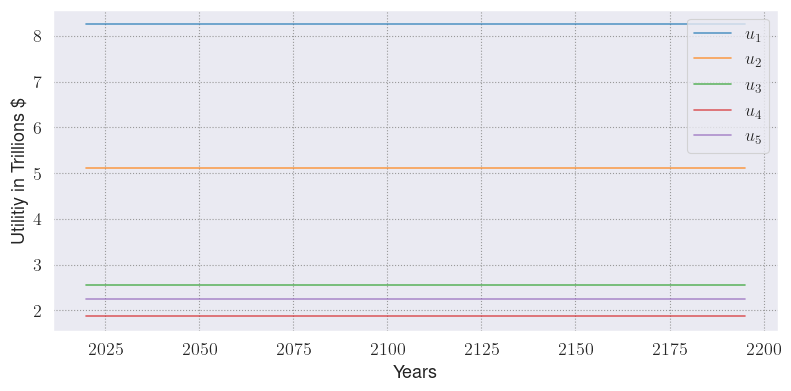

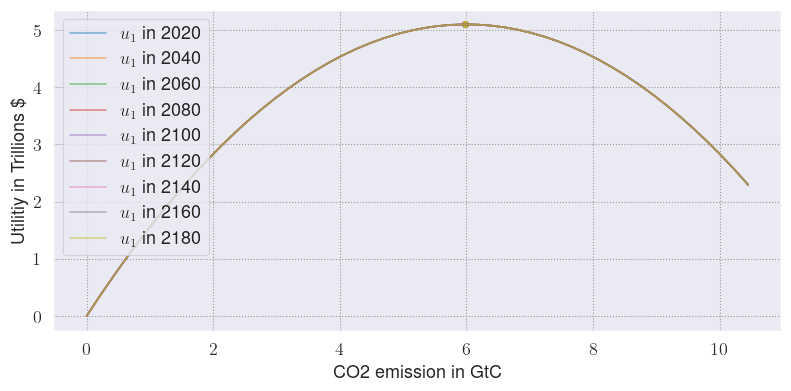

$u_2 = -0.1417 a_2^2 + 1.70 a_2 - (0y_{AT}^2 0 y_{AT})$


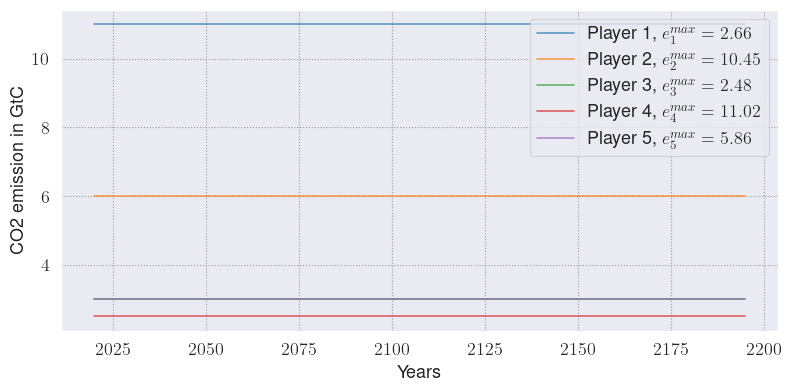

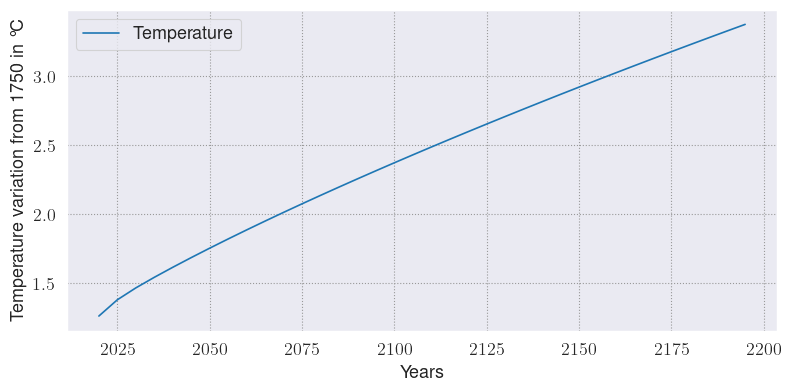

In [24]:
import scipy.stats as stats



alea_1 = stats.randint.rvs(size=N, low=5, high=8, random_state=96)/10 + 1
list_benef_coef = [np.array([0, alea_1[i] , - alea_1[i] / (2 * action_sets[i][1])]) for i in range(N)]


damage_coef = np.array([0,-5,5])*0 # shift


list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = deltas[i]) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, EMISSION_TREE, F_EX)


from numpy import argmax, size
import seaborn as sns

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    y = np.zeros(T)
    for t in range(T):
        y[t] = list_players[i].utility_one_shot_with_temp(array_action[i,t], list_temp[t])
    plt.plot(2020 + np.arange(T)*5, y, label='$u_{}$'.format(i+1), alpha = 0.7)
    # plt.plot(2020 + np.arange(T)*5, y, label=r'$\beta_{} = {:.4f}$, '.format(r'{{2,{}}}'.format(i+1), alea_1[i]*benef_coef[2]) + r'$\beta_{{1,{}}} = {:.2f}$'.format(i+1, alea_1[i])+' and $\delta_{} = {:.2f}$'.format( i+1, list_players[i].delta), alpha = 0.5)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('Years')
# plt.title('Utilities of players')
plt.legend()
plt.savefig('plots/simu_utilities_no_damage.pdf', format='pdf')
plt.show()


################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

indice = 1
list_players[indice].smc.reset_carbon_model()
list_players[indice].smc.reset_temperature_dynamic()

for t in range(0,T):
    x = np.linspace(0,np.sum(list_action_set[:][1]))
    y = np.zeros_like(x)
    k=0
    
    for point in x:
        y[k] = list_players[indice].utility_one_shot(point,array_sum_action[t] - array_action[indice][t],array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    
        k+=1
    list_players[indice].update_smc(array_sum_action[t], array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    if t%4==0:
        plt.plot(x, y, label=r'$u_{}$ in {}'.format(indice,2020 + t*5), alpha = 0.5)
        xmax = x[np.argmax(y)]
        ymax = y.max()
        plt.scatter( xmax, ymax, s=15)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('CO2 emission in GtC')
# plt.title(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
plt.legend(loc = 'upper left')
plt.savefig('plots/simu_individual_utilities_no_damage.pdf', format='pdf')
plt.show()

print(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    plt.plot(2020 + np.arange(T)*5, array_action[i], label='Player {}, $e^{{max}}_{} = {:.2f}$'.format(i+1, i+1, list_action_set[i][1]), alpha = 0.7)

plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')

# plt.title('Players\' actions with respect to the state')
plt.legend()

plt.savefig('plots/simu_actions_no_damage.pdf', format='pdf')
plt.show()

################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

plt.plot(2020 + np.arange(T)*5, list_temp, label='Temperature')

plt.ylabel('Temperature variation from 1750 in °C')
plt.xlabel('Years')

# plt.title('Temperature evolution from 2020 to 2200')
plt.legend()

plt.savefig('plots/simu_temp_no_damage.pdf', format='pdf')
plt.show()

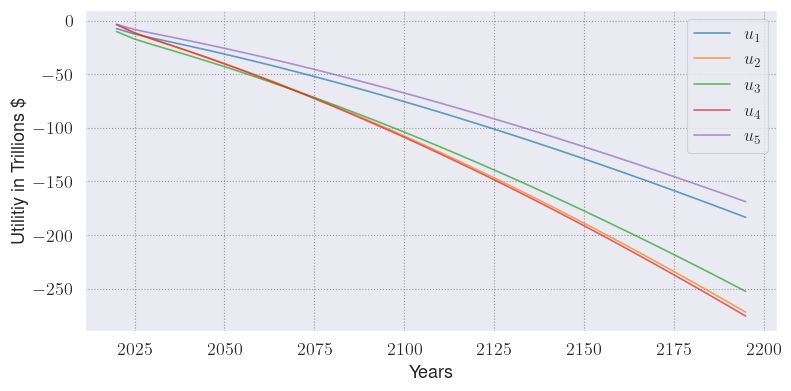

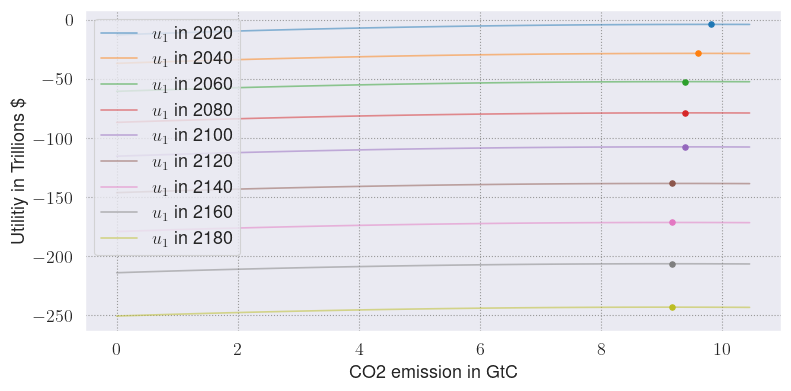

$u_2 = -0.0914 a_2^2 + 1.91 a_2 - (10y_{AT}^2 -10 y_{AT})$


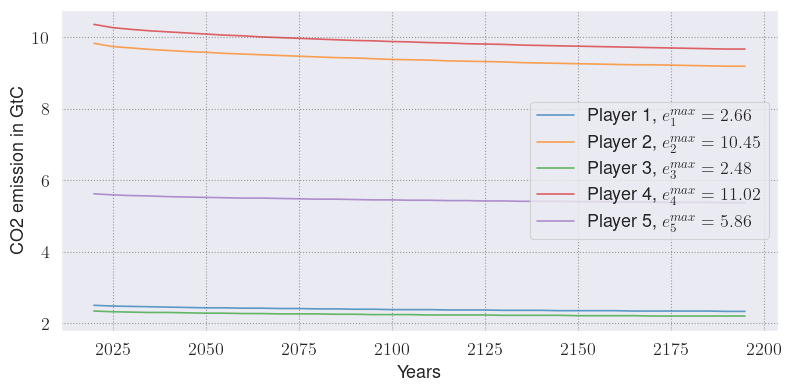

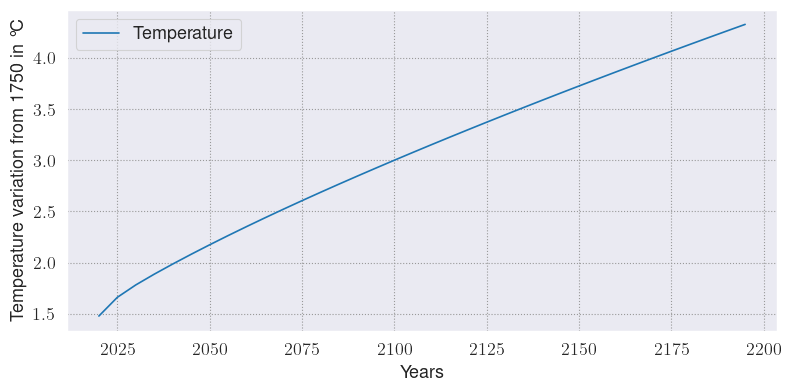

In [159]:
import scipy.stats as stats


N = 5
T = 36
action_set = np.array([0.0, 12.0])
alea_0 = stats.uniform.rvs(size = N, random_state=5)

list_action_set = [action_set * alea_0[i] for i in range(N)]

alea_1 = stats.uniform.rvs(size=N, random_state=96)+1
list_benef_coef = [np.array([0, alea_1[i] * 1.0, - alea_1[i] / (2 * list_action_set[i][1])]) for i in range(N)]

damage_coef = np.array([0,-10,10]) # shift

benefit_function = polynome(benef_coef)
damage_function = polynome(damage_coef)
carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)
delta = 1
exogeneous_emission = 2.6
array_exogeneous_emission = np.ones(T) * exogeneous_emission

alea = stats.uniform.rvs(size = N, random_state=31)
# alea = np.ones_like(alea)

exogeneous_radiative_forcing = 1
array_exogeneous_radiative_forcing = np.linspace(exogeneous_radiative_forcing, exogeneous_radiative_forcing * 2, num=T)


list_players = [player_class(name = 'player {}'.format(i), action_set = list_action_set[i], smc = deepcopy(smc),
                                benefit_function = polynome(list_benef_coef[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = 1 + delta * alea[i]) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])
# list_actions = np.zeros_like([player.action_set[1] for player in list_players])*

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, array_exogeneous_emission, array_exogeneous_radiative_forcing)


from numpy import argmax, size
import seaborn as sns

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    y = np.zeros(T)
    for t in range(T):
        y[t] = list_players[i].utility_one_shot_with_temp(array_action[i,t], list_temp[t])
    plt.plot(2020 + np.arange(T)*5, y, label='$u_{}$'.format(i+1), alpha = 0.7)
    # plt.plot(2020 + np.arange(T)*5, y, label=r'$\beta_{} = {:.4f}$, '.format(r'{{2,{}}}'.format(i+1), alea_1[i]*benef_coef[2]) + r'$\beta_{{1,{}}} = {:.2f}$'.format(i+1, alea_1[i])+' and $\delta_{} = {:.2f}$'.format( i+1, list_players[i].delta), alpha = 0.5)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('Years')
# plt.title('Utilities of players')
plt.legend()
plt.savefig('plots/simu_utilities_concave.pdf', format='pdf')
plt.show()


################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

indice = 1
list_players[indice].smc.reset_carbon_model()
list_players[indice].smc.reset_temperature_dynamic()

for t in range(0,T):
    x = np.linspace(0,np.sum(list_action_set[:][1]))
    y = np.zeros_like(x)
    k=0
    
    for point in x:
        y[k] = list_players[indice].utility_one_shot(point,array_sum_action[t] - array_action[indice][t],array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    
        k+=1
    list_players[indice].update_smc(array_sum_action[t], array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    if t%4==0:
        plt.plot(x, y, label=r'$u_{}$ in {}'.format(indice,2020 + t*5), alpha = 0.5)
        xmax = x[np.argmax(y)]
        ymax = y.max()
        plt.scatter( xmax, ymax, s=15)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('CO2 emission in GtC')
# plt.title(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
plt.legend(loc = 'upper left')
plt.savefig('plots/simu_individual_utilities_concave.pdf', format='pdf')
plt.show()

print(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    plt.plot(2020 + np.arange(T)*5, array_action[i], label='Player {}, $e^{{max}}_{} = {:.2f}$'.format(i+1, i+1, list_action_set[i][1]), alpha = 0.7)

plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')

# plt.title('Players\' actions with respect to the state')
plt.legend()

plt.savefig('plots/simu_actions_concave.pdf', format='pdf')
plt.show()

################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

plt.plot(2020 + np.arange(T)*5, list_temp, label='Temperature')

plt.ylabel('Temperature variation from 1750 in °C')
plt.xlabel('Years')

# plt.title('Temperature evolution from 2020 to 2200')
plt.legend()

plt.savefig('plots/simu_temp_concave.pdf', format='pdf')
plt.show()

In [165]:
for i in range(N):
    print(list_action_set[i])

[0.         2.66391805]
[ 0.         10.44878767]
[0.         2.48062986]
[ 0.        11.0233309]
[0.         5.86093427]


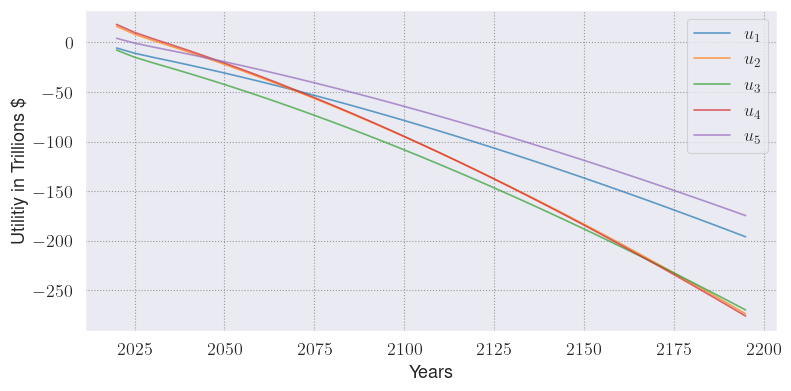

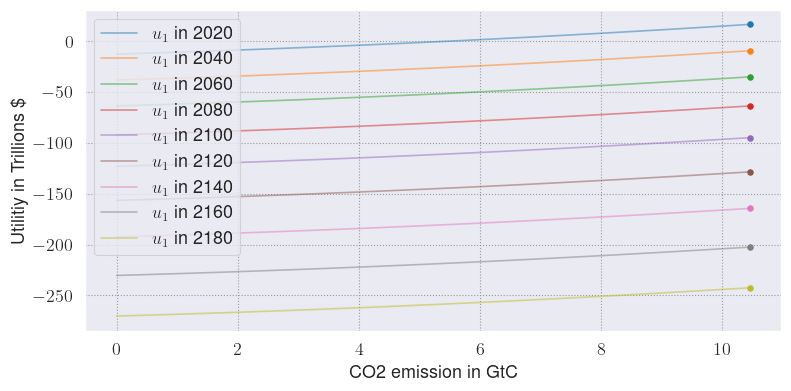

$u_2 = -0.0914 a_2^2 + 1.91 a_2 - (10y_{AT}^2 -10 y_{AT})$


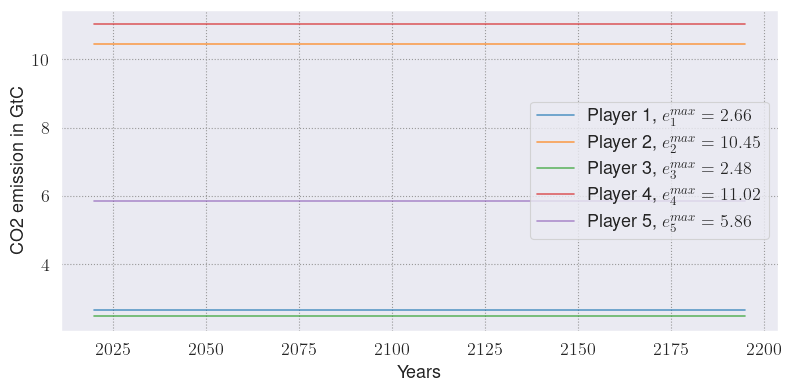

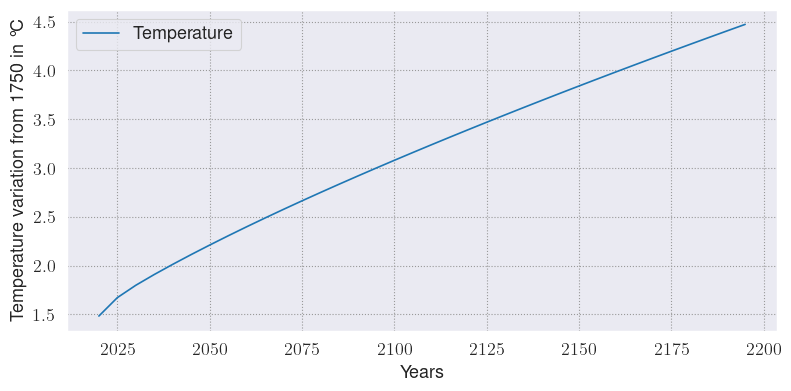

In [160]:
import scipy.stats as stats


N = 5
T = 36
action_set = np.array([0.0, 12.0])
alea_0 = stats.uniform.rvs(size = N, random_state=5)

list_action_set = [action_set * alea_0[i] for i in range(N)]
alea_1 = stats.uniform.rvs(size=N, random_state=96)+1

damage_coef = np.array([0,-10,10]) # shift

benef_coef = np.array([0,1,0.05])

benefit_function = polynome(benef_coef)
damage_function = polynome(damage_coef)
carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)
delta = 1
exogeneous_emission = 2.6
array_exogeneous_emission = np.ones(T) * exogeneous_emission

alea = stats.uniform.rvs(size = N, random_state=31)
# alea = np.ones_like(alea)

exogeneous_radiative_forcing = 1
array_exogeneous_radiative_forcing = np.linspace(exogeneous_radiative_forcing, exogeneous_radiative_forcing * 2, num=T)


list_players = [player_class(name = 'player {}'.format(i), action_set = list_action_set[i], smc = deepcopy(smc),
                                benefit_function = polynome(benef_coef*alea_1[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = 1 + delta * alea[i]) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])
# list_actions = np.zeros_like([player.action_set[1] for player in list_players])*

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, array_exogeneous_emission, array_exogeneous_radiative_forcing)

from numpy import argmax, size
import seaborn as sns

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    y = np.zeros(T)
    for t in range(T):
        y[t] = list_players[i].utility_one_shot_with_temp(array_action[i,t], list_temp[t])
    plt.plot(2020 + np.arange(T)*5, y, label='$u_{}$'.format(i+1), alpha = 0.7)
    # plt.plot(2020 + np.arange(T)*5, y, label=r'$\beta_{} = {:.4f}$, '.format(r'{{2,{}}}'.format(i+1), alea_1[i]*benef_coef[2]) + r'$\beta_{{1,{}}} = {:.2f}$'.format(i+1, alea_1[i])+' and $\delta_{} = {:.2f}$'.format( i+1, list_players[i].delta), alpha = 0.5)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('Years')
# plt.title('Utilities of players')
plt.legend()
plt.savefig('plots/simu_utilities_convex.pdf', format='pdf')
plt.show()


################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

indice = 1
list_players[indice].smc.reset_carbon_model()
list_players[indice].smc.reset_temperature_dynamic()

for t in range(0,T):
    x = np.linspace(0,np.sum(list_action_set[:][1]))
    y = np.zeros_like(x)
    k=0
    
    for point in x:
        y[k] = list_players[indice].utility_one_shot(point,array_sum_action[t] - array_action[indice][t],array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    
        k+=1
    list_players[indice].update_smc(array_sum_action[t], array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    if t%4==0:
        plt.plot(x, y, label=r'$u_{}$ in {}'.format(indice,2020 + t*5), alpha = 0.5)
        xmax = x[np.argmax(y)]
        ymax = y.max()
        plt.scatter( xmax, ymax, s=15)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('CO2 emission in GtC')
# plt.title(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
plt.legend(loc = 'upper left')
plt.savefig('plots/simu_individual_utilities_convex.pdf', format='pdf')
plt.show()

print(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    plt.plot(2020 + np.arange(T)*5, array_action[i], label='Player {}, $e^{{max}}_{} = {:.2f}$'.format(i+1, i+1, list_action_set[i][1]), alpha = 0.7)

plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')

# plt.title('Players\' actions with respect to the state')
plt.legend()

plt.savefig('plots/simu_actions_convex.pdf', format='pdf')
plt.show()

################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

plt.plot(2020 + np.arange(T)*5, list_temp, label='Temperature')

plt.ylabel('Temperature variation from 1750 in °C')
plt.xlabel('Years')

# plt.title('Temperature evolution from 2020 to 2200')
plt.legend()

plt.savefig('plots/simu_temp_convex.pdf', format='pdf')
plt.show()

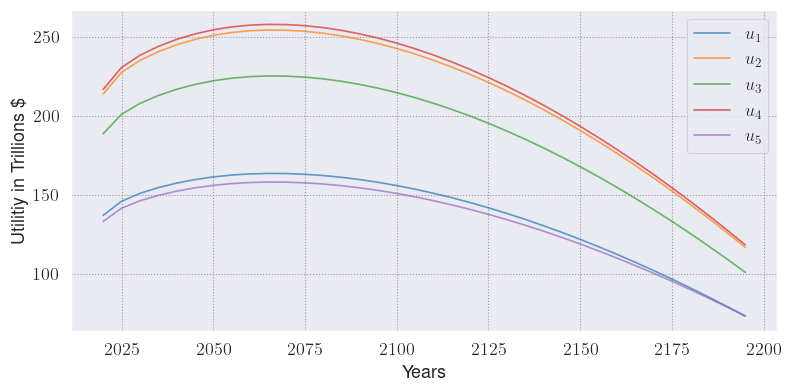

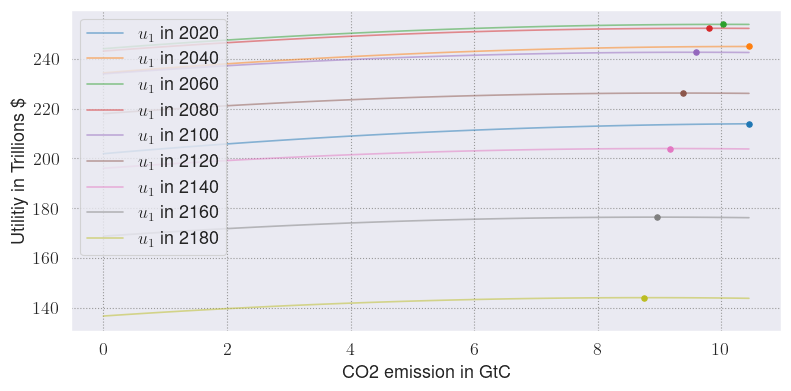

$u_2 = -0.0914 a_2^2 + 1.91 a_2 - (20y_{AT}^2 -100 y_{AT})$


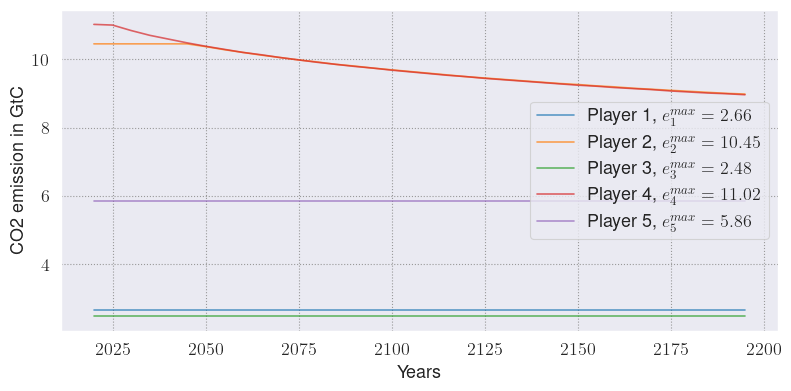

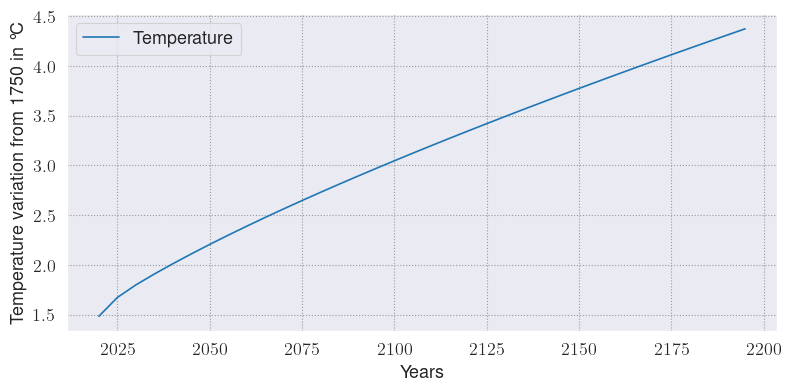

In [161]:
import scipy.stats as stats


N = 5
T = 36
action_set = np.array([0.0, 12.0])
alea_0 = stats.uniform.rvs(size = N, random_state=5)

list_action_set = [action_set * alea_0[i] for i in range(N)]
alea_1 = stats.uniform.rvs(size=N, random_state=96)+1

damage_coef = np.array([0,-100,20]) 

benef_coef = np.array([0,1,-0.05])

benefit_function = polynome(benef_coef)
damage_function = polynome(damage_coef)
carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)
delta = 1
exogeneous_emission = 2.6
array_exogeneous_emission = np.ones(T) * exogeneous_emission

alea = stats.uniform.rvs(size = N, random_state=31)
# alea = np.ones_like(alea)

exogeneous_radiative_forcing = 1
array_exogeneous_radiative_forcing = np.linspace(exogeneous_radiative_forcing, exogeneous_radiative_forcing * 2, num=T)


list_players = [player_class(name = 'player {}'.format(i), action_set = list_action_set[i], smc = deepcopy(smc),
                                benefit_function = polynome(benef_coef*alea_1[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = 1 + delta * alea[i]) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])
# list_actions = np.zeros_like([player.action_set[1] for player in list_players])*

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, array_exogeneous_emission, array_exogeneous_radiative_forcing)

from numpy import argmax, size
import seaborn as sns

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    y = np.zeros(T)
    for t in range(T):
        y[t] = list_players[i].utility_one_shot_with_temp(array_action[i,t], list_temp[t])
    plt.plot(2020 + np.arange(T)*5, y, label='$u_{}$'.format(i+1), alpha = 0.7)
    # plt.plot(2020 + np.arange(T)*5, y, label=r'$\beta_{} = {:.4f}$, '.format(r'{{2,{}}}'.format(i+1), alea_1[i]*benef_coef[2]) + r'$\beta_{{1,{}}} = {:.2f}$'.format(i+1, alea_1[i])+' and $\delta_{} = {:.2f}$'.format( i+1, list_players[i].delta), alpha = 0.5)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('Years')
# plt.title('Utilities of players')
plt.legend()
plt.savefig('plots/simu_utilities_concave_plus.pdf', format='pdf')
plt.show()


################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

indice = 1
list_players[indice].smc.reset_carbon_model()
list_players[indice].smc.reset_temperature_dynamic()

for t in range(0,T):
    x = np.linspace(0,np.sum(list_action_set[:][1]))
    y = np.zeros_like(x)
    k=0
    
    for point in x:
        y[k] = list_players[indice].utility_one_shot(point,array_sum_action[t] - array_action[indice][t],array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    
        k+=1
    list_players[indice].update_smc(array_sum_action[t], array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    if t%4==0:
        plt.plot(x, y, label=r'$u_{}$ in {}'.format(indice,2020 + t*5), alpha = 0.5)
        xmax = x[np.argmax(y)]
        ymax = y.max()
        plt.scatter( xmax, ymax, s=15)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('CO2 emission in GtC')
# plt.title(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
plt.legend(loc = 'upper left')
plt.savefig('plots/simu_individual_utilities_concave_plus.pdf', format='pdf')
plt.show()

print(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    plt.plot(2020 + np.arange(T)*5, array_action[i], label='Player {}, $e^{{max}}_{} = {:.2f}$'.format(i+1, i+1, list_action_set[i][1]), alpha = 0.7)

plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')

# plt.title('Players\' actions with respect to the state')
plt.legend()

plt.savefig('plots/simu_actions_concave_plus.pdf', format='pdf')
plt.show()

################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

plt.plot(2020 + np.arange(T)*5, list_temp, label='Temperature')

plt.ylabel('Temperature variation from 1750 in °C')
plt.xlabel('Years')

# plt.title('Temperature evolution from 2020 to 2200')
plt.legend()

plt.savefig('plots/simu_temp_concave_plus.pdf', format='pdf')
plt.show()

## Convex benefit

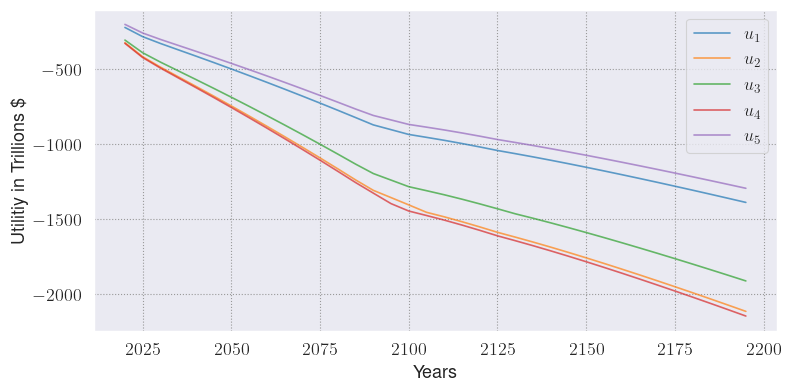

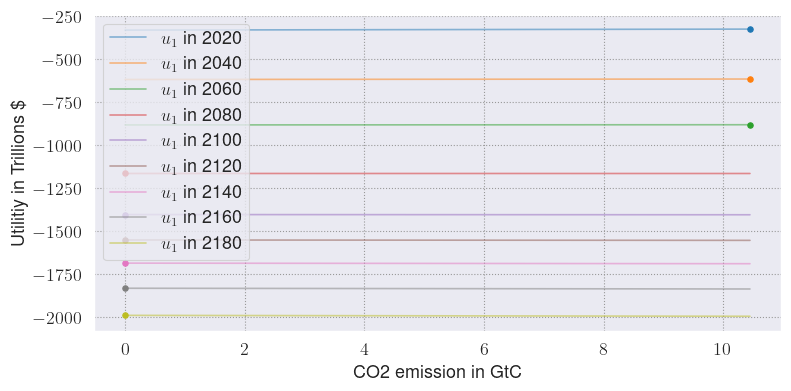

$u_2 = -0.0914 a_2^2 + 1.91 a_2 - (80y_{AT}^2 0 y_{AT})$


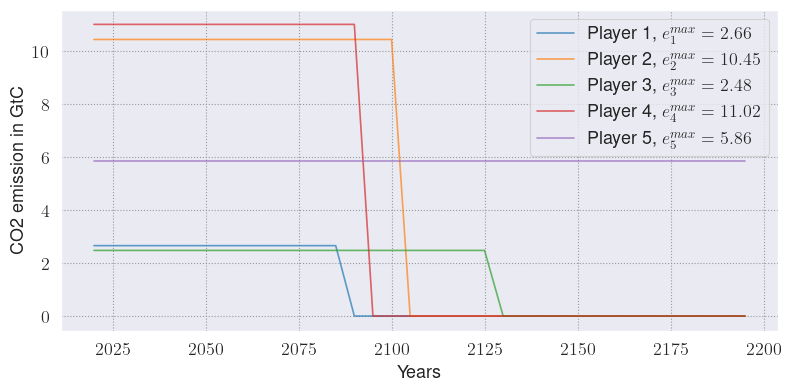

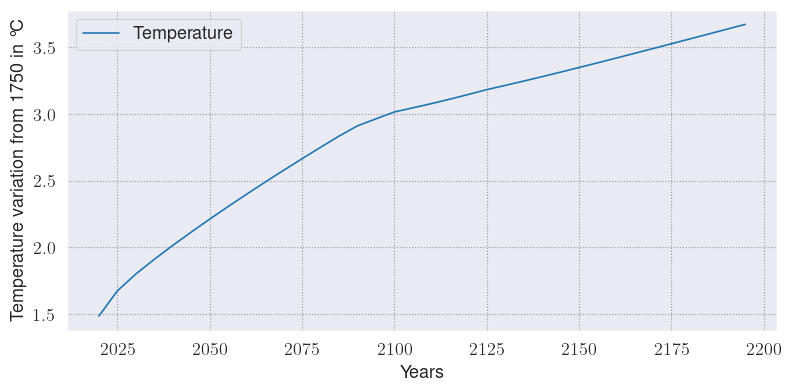

In [162]:
import scipy.stats as stats


N = 5
T = 36
action_set = np.array([0.0, 12.0])
alea_0 = stats.uniform.rvs(size = N, random_state=5)

list_action_set = [action_set * alea_0[i] for i in range(N)]
alea_1 = stats.uniform.rvs(size=N, random_state=96)+1

damage_coef = np.array([0,0,80]) 

benef_coef = np.array([0,1,0])

benefit_function = polynome(benef_coef)
damage_function = polynome(damage_coef)
carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)
delta = 1
exogeneous_emission = 2.6
array_exogeneous_emission = np.ones(T) * exogeneous_emission

alea = stats.uniform.rvs(size = N, random_state=31)
# alea = np.ones_like(alea)

exogeneous_radiative_forcing = 1
array_exogeneous_radiative_forcing = np.linspace(exogeneous_radiative_forcing, exogeneous_radiative_forcing * 2, num=T)


list_players = [player_class(name = 'player {}'.format(i), action_set = list_action_set[i], smc = deepcopy(smc),
                                benefit_function = polynome(benef_coef*alea_1[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = 1 + delta * alea[i]) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])
# list_actions = np.zeros_like([player.action_set[1] for player in list_players])*

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, array_exogeneous_emission, array_exogeneous_radiative_forcing)

from numpy import argmax, size
import seaborn as sns

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    y = np.zeros(T)
    for t in range(T):
        y[t] = list_players[i].utility_one_shot_with_temp(array_action[i,t], list_temp[t])
    plt.plot(2020 + np.arange(T)*5, y, label='$u_{}$'.format(i+1), alpha = 0.7)
    # plt.plot(2020 + np.arange(T)*5, y, label=r'$\beta_{} = {:.4f}$, '.format(r'{{2,{}}}'.format(i+1), alea_1[i]*benef_coef[2]) + r'$\beta_{{1,{}}} = {:.2f}$'.format(i+1, alea_1[i])+' and $\delta_{} = {:.2f}$'.format( i+1, list_players[i].delta), alpha = 0.5)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('Years')
# plt.title('Utilities of players')
plt.legend()
plt.savefig('plots/simu_utilities_benef_convex.pdf', format='pdf')
plt.show()


################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

indice = 1
list_players[indice].smc.reset_carbon_model()
list_players[indice].smc.reset_temperature_dynamic()

for t in range(0,T):
    x = np.linspace(0,np.sum(list_action_set[:][1]))
    y = np.zeros_like(x)
    k=0
    
    for point in x:
        y[k] = list_players[indice].utility_one_shot(point,array_sum_action[t] - array_action[indice][t],array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    
        k+=1
    list_players[indice].update_smc(array_sum_action[t], array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    if t%4==0:
        plt.plot(x, y, label=r'$u_{}$ in {}'.format(indice,2020 + t*5), alpha = 0.5)
        xmax = x[np.argmax(y)]
        ymax = y.max()
        plt.scatter( xmax, ymax, s=15)

plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('CO2 emission in GtC')
# plt.title(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
plt.legend(loc = 'upper left')
plt.savefig('plots/simu_individual_utilities_benef_convex.pdf', format='pdf')
plt.show()

print(r'$u_{} = {:.4f} a_{}^2 + {:.2f} a_{} - ({}y_{{AT}}^2 {} y_{{AT}})$'.format(indice+1,list_benef_coef[indice][2], indice+1,  list_benef_coef[indice][1] , indice+1, damage_coef[-1],damage_coef[-2]))
################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

for i in range(N):
    plt.plot(2020 + np.arange(T)*5, array_action[i], label='Player {}, $e^{{max}}_{} = {:.2f}$'.format(i+1, i+1, list_action_set[i][1]), alpha = 0.7)

plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')

# plt.title('Players\' actions with respect to the state')
plt.legend()

plt.savefig('plots/simu_actions_benef_convex.pdf', format='pdf')
plt.show()

################################################

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)

plt.plot(2020 + np.arange(T)*5, list_temp, label='Temperature')

plt.ylabel('Temperature variation from 1750 in °C')
plt.xlabel('Years')

# plt.title('Temperature evolution from 2020 to 2200')
plt.legend()

plt.savefig('plots/simu_temp_benef_convex.pdf', format='pdf')
plt.show()

In [166]:
for i in range(N):
    print(benef_coef*alea_1[i])

[0.         1.21468689 0.        ]
[0.         1.90950237 0.        ]
[0.         1.81723537 0.        ]
[0.         1.90388047 0.        ]
[0.         1.70687927 0.        ]


In [63]:
data = pd.read_csv('data/DATA.csv')


In [64]:
data

,Unnamed: 0,Entity,Year,CO2,GDP,POP,Impact Factor
0,0,Afghanistan,1950,84272,1156.000000,7752117.0,0.9074
1,1,Afghanistan,1951,91600,1170.000000,7840151.0,0.9074
2,2,Afghanistan,1952,91600,1189.000000,7935996.0,0.9074
3,3,Afghanistan,1953,106256,1240.000000,8039684.0,0.9074
4,4,Afghanistan,1954,106256,1245.000000,8151316.0,0.9074
...,...,...,...,...,...,...,...
13278,13278,Zimbabwe,2014,11905687,1594.000000,13586710.0,0.8780
13279,13279,Zimbabwe,2015,12225821,1560.000000,13814642.0,0.8780
13280,13280,Zimbabwe,2016,10737567,1534.000000,14030338.0,0.8780
13281,13281,Zimbabwe,2017,9581633,1582.366211,14236599.0,0.8780


[0, 0.557901]
[0, 10.289989525]
[0, 0.537406556]
[0, 1.117888357]
[0, 2.599805717]
[0, 1.315342658]
[0, 2.525517951]
[0, 6.134521473]


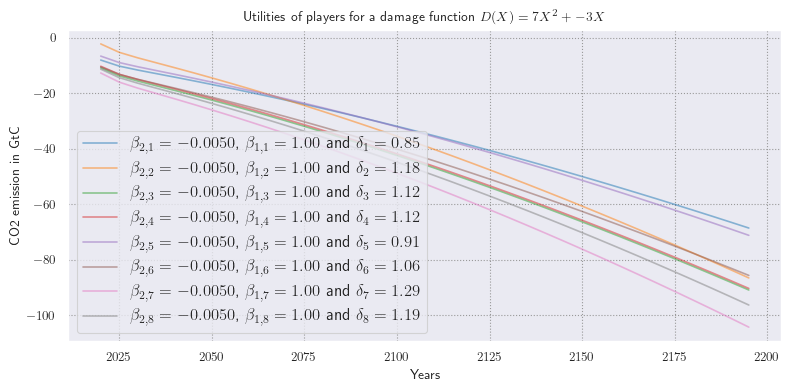

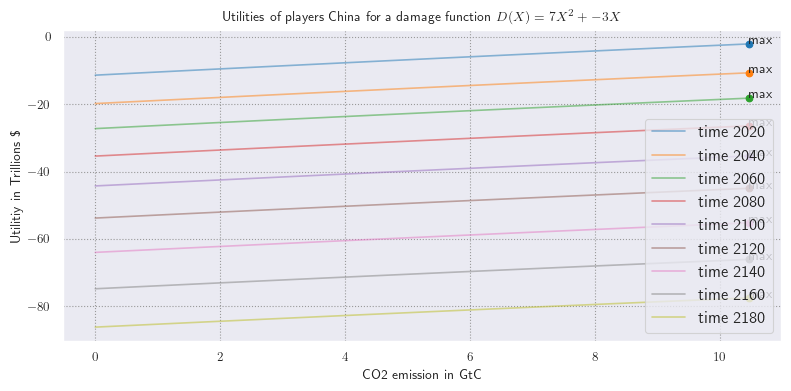

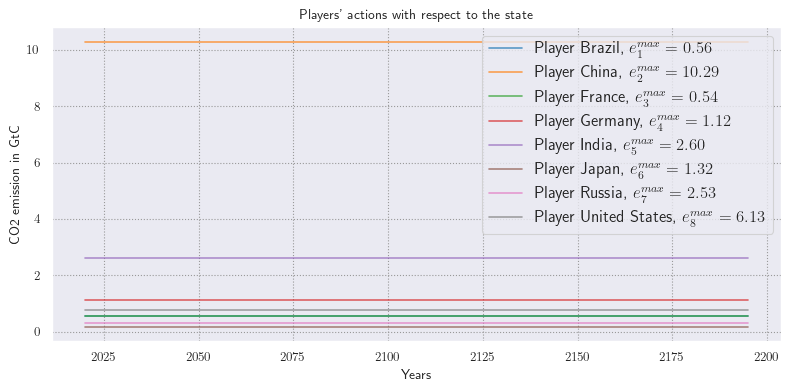

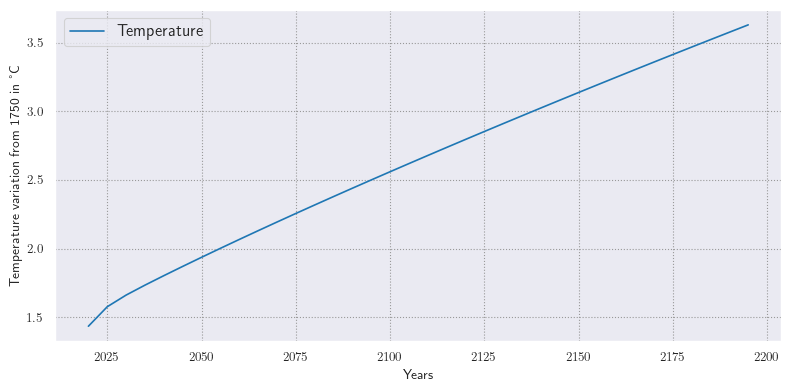

In [65]:
T = 36


carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)

exogeneous_emission = 2.6
array_exogeneous_emission = np.ones(T) * exogeneous_emission


exogeneous_radiative_forcing = 1
array_exogeneous_radiative_forcing = np.linspace(exogeneous_radiative_forcing, exogeneous_radiative_forcing * 2, num=T)




LIST_COUNTRIES = sorted(['China','United States', 'India', 'Russia', 'Japan', 'Brazil', 'France', 'Germany'])
min_year = 1950
standard_smc = geophysics(carbon_model, temperature_model)

damage_coef = np.array([0,-3,7]) 
damage_function = polynome(damage_coef)

list_players = []
for contry in LIST_COUNTRIES:

    #Data 
    new_data = data.loc[data['Entity'] == contry ]
    new_data = new_data[new_data['Year'] >= min_year]

    # action set
    e_min = 0
    e_max = new_data['CO2'].max() / 1E9
    action_set = [e_min, e_max]
    print(action_set)
    # SMC
    smc_player = deepcopy(standard_smc)

    # Benefit function
    benef_coef = np.array([0,1,-0.005])
    benefit_function = polynome(benef_coef)

    # impact factor 

    impact_factor = new_data['Impact Factor'].max()

    list_players.append(player_class(name = contry,
                    action_set = action_set,
                    smc = smc_player,
                    benefit_function = polynome(benef_coef),
                    damage_function = polynome(damage_coef),
                    impact_factor_of_temperature = impact_factor ))

list_actions = np.array([player.action_set[1] for player in list_players])
 
array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, array_exogeneous_emission, array_exogeneous_radiative_forcing)

import matplotlib
from numpy import argmax, size
import seaborn as sns

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)
# plt.grid(which='both')
sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
for i in range(len(list_players)):
    player = list_players[i]
    y = np.zeros(T)
    for t in range(T):
        y[t] = player.utility_one_shot_with_temp(array_action[i,t], list_temp[t])
    plt.plot(2020 + np.arange(T)*5, y, label=r'$\beta_{} = {:.4f}$, '.format(r'{{2,{}}}'.format(i+1), benef_coef[2]) + 
    r'$\beta_{{1,{}}} = {:.2f}$'.format(i+1,benef_coef[1])+' and $\delta_{} = {:.2f}$'.format( i+1, player.delta), alpha = 0.5)

plt.legend()
plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')
plt.title('Utilities of players for a damage function $D(X) = {}X^2 +{}X$'.format(damage_coef[-1],damage_coef[-2]))
plt.legend(prop={'size': 12})
plt.savefig('plots/simu_utilities.pdf', format='pdf')
plt.show()

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)
# plt.grid(which='both')
sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
indice = 1
player = list_players[indice]
player.smc.reset_carbon_model()
player.smc.reset_temperature_dynamic()

for t in range(0,T):
    x = np.linspace(0,np.sum(list_action_set[:][1]))
    y = np.zeros_like(x)
    k=0
    
    for point in x:
        y[k] = player.utility_one_shot(point,array_sum_action[t] - array_action[indice][t],array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    
        k+=1
    player.update_smc(array_sum_action[t], array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    if t%4==0:
        plt.plot(x, y, label=r'time {}'.format(2020 + t*5), alpha = 0.5)
        xmax = x[np.argmax(y)]
        ymax = y.max()
        plt.scatter( xmax, ymax)

        plt.annotate('max', (xmax, ymax))
plt.legend()
plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('CO2 emission in GtC')
plt.title('Utilities of players {} for a damage function $D(X) = {}X^2 +{}X$'.format(player.name, damage_coef[-1],damage_coef[-2]))
plt.legend(prop={'size': 12})
plt.savefig('plots/simu_individual_utilities.pdf', format='pdf')
plt.show()

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)
# plt.grid(which='both')
sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")

for i in range(len(list_players)):
    player = list_players[i]
    plt.plot(2020 + np.arange(T)*5, array_action[i], label='Player {}, $e^{{max}}_{} = {:.2f}$'.format(player.name, i+1, player.action_set[1]), alpha = 0.7)

plt.legend()
plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')
plt.title('Players\' actions with respect to the state')
plt.legend(prop={'size': 12})
plt.savefig('plots/simu_actions.pdf', format='pdf')
plt.show()

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)
# plt.grid(which='both')
sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
plt.plot(2020 + np.arange(T)*5, list_temp, label='Temperature')
plt.ylabel('Temperature variation from 1750 in °C')
plt.xlabel('Years')
plt.legend(prop={'size': 12})
plt.savefig('plots/simu_temp.pdf', format='pdf')
plt.show()

In [23]:
sorted(['China','United States', 'India', 'Russia', 'Japan', 'Brazil', 'France', 'Germany'])

['Brazil',
 'China',
 'France',
 'Germany',
 'India',
 'Japan',
 'Russia',
 'United States']

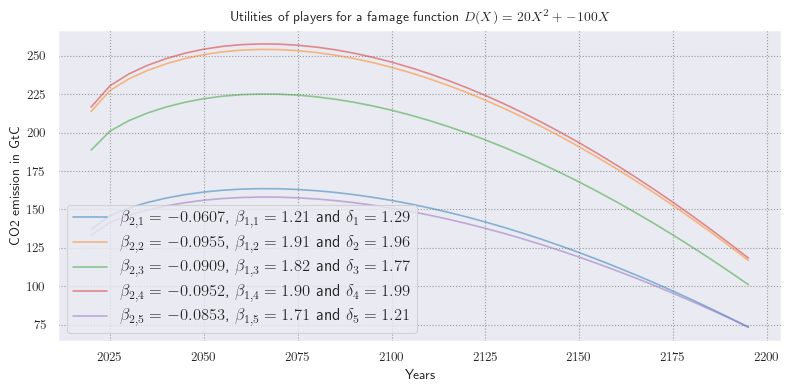

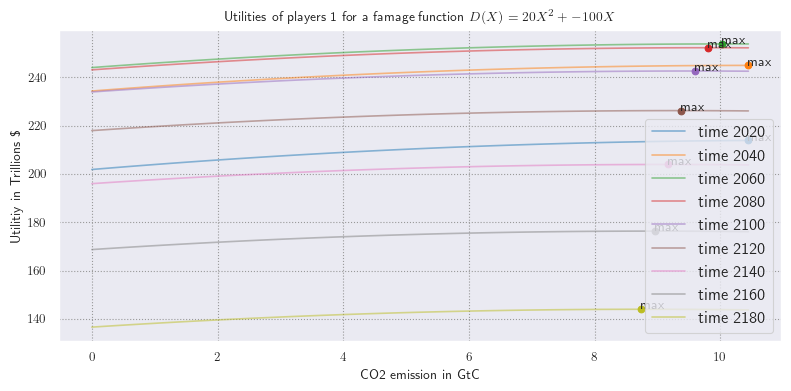

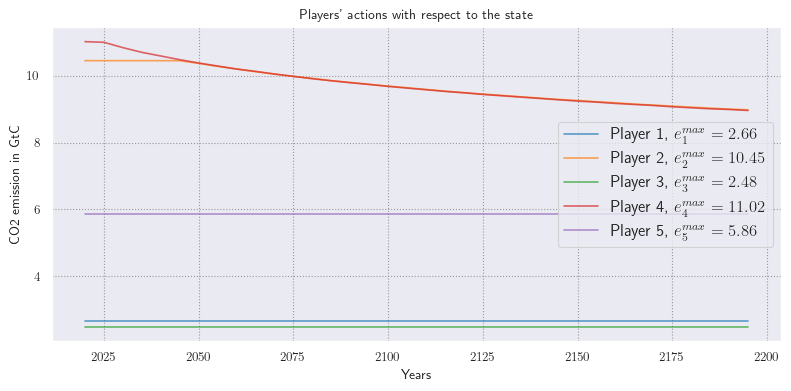

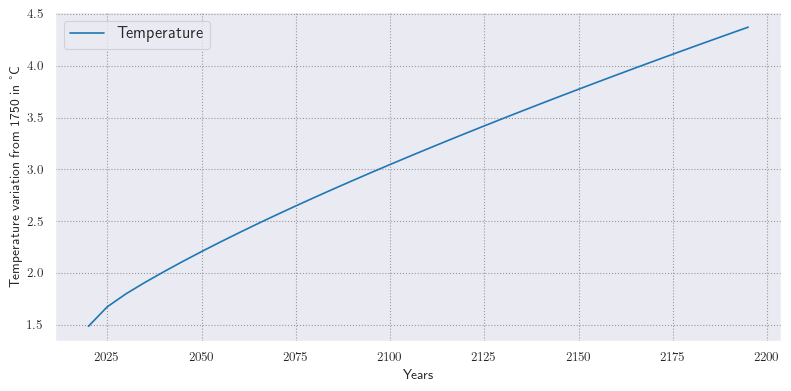

In [66]:
import scipy.stats as stats


T = 36

action_set = np.array([0.0, 12.0])

list_action_set = [action_set * alea_0[i] for i in range(N)]
alea_1 = stats.uniform.rvs(size=N, random_state=96)+1

damage_coef = np.array([0,-100,20]) 

benef_coef = np.array([0,1,-0.05])

benefit_function = polynome(benef_coef)
damage_function = polynome(damage_coef)
carbon_model = Carbon_JOOS()
temperature_model = Temp_Discret_Geoffroy()
smc = geophysics(carbon_model, temperature_model)
delta = 1
exogeneous_emission = 2.6
array_exogeneous_emission = np.ones(T) * exogeneous_emission

alea = stats.uniform.rvs(size = N, random_state=31)
# alea = np.ones_like(alea)

exogeneous_radiative_forcing = 1
array_exogeneous_radiative_forcing = np.linspace(exogeneous_radiative_forcing, exogeneous_radiative_forcing * 2, num=T)


list_players = [player_class(name = 'player {}'.format(i), action_set = list_action_set[i], smc = deepcopy(smc),
                                benefit_function = polynome(benef_coef*alea_1[i]), damage_function = polynome(damage_coef),
                                impact_factor_of_temperature = 1 + delta * alea[i]) for i in range(N)]

list_actions = np.array([player.action_set[1] for player in list_players])
# list_actions = np.zeros_like([player.action_set[1] for player in list_players])*

array_action, array_sum_action, list_temp= repeated_one_shot_game(list_players, carbon_model, temperature_model, array_exogeneous_emission, array_exogeneous_radiative_forcing)

import matplotlib
from numpy import argmax, size
import seaborn as sns

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)
# plt.grid(which='both')
sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
for i in range(N):
    y = np.zeros(T)
    for t in range(T):
        y[t] = list_players[i].utility_one_shot_with_temp(array_action[i,t], list_temp[t])
    plt.plot(2020 + np.arange(T)*5, y, label=r'$\beta_{} = {:.4f}$, '.format(r'{{2,{}}}'.format(i+1), alea_1[i]*benef_coef[2]) + r'$\beta_{{1,{}}} = {:.2f}$'.format(i+1, alea_1[i])+' and $\delta_{} = {:.2f}$'.format( i+1, list_players[i].delta), alpha = 0.5)

plt.legend()
plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')
plt.title('Utilities of players for a famage function $D(X) = {}X^2 +{}X$'.format(damage_coef[-1],damage_coef[-2]))
plt.legend(prop={'size': 12})
plt.savefig('plots/simu_utilities.pdf', format='pdf')
plt.show()

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)
# plt.grid(which='both')
sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
indice = 1
list_players[indice].smc.reset_carbon_model()
list_players[indice].smc.reset_temperature_dynamic()

for t in range(0,T):
    x = np.linspace(0,np.sum(list_action_set[:][1]))
    y = np.zeros_like(x)
    k=0
    
    for point in x:
        y[k] = list_players[indice].utility_one_shot(point,array_sum_action[t] - array_action[indice][t],array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    
        k+=1
    list_players[indice].update_smc(array_sum_action[t], array_exogeneous_emission[t],array_exogeneous_radiative_forcing[t])
    if t%4==0:
        plt.plot(x, y, label=r'time {}'.format(2020 + t*5), alpha = 0.5)
        xmax = x[np.argmax(y)]
        ymax = y.max()
        plt.scatter( xmax, ymax)

        plt.annotate('max', (xmax, ymax))
plt.legend()
plt.ylabel(r'Utilitiy in Trillions \$')
plt.xlabel('CO2 emission in GtC')
plt.title('Utilities of players {} for a famage function $D(X) = {}X^2 +{}X$'.format(indice, damage_coef[-1],damage_coef[-2]))
plt.legend(prop={'size': 12})
plt.savefig('plots/simu_individual_utilities.pdf', format='pdf')
plt.show()

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)
# plt.grid(which='both')
sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")

for i in range(N):
    plt.plot(2020 + np.arange(T)*5, array_action[i], label='Player {}, $e^{{max}}_{} = {:.2f}$'.format(i+1, i+1, list_action_set[i][1]), alpha = 0.7)

plt.legend()
plt.ylabel('CO2 emission in GtC')
plt.xlabel('Years')
plt.title('Players\' actions with respect to the state')
plt.legend(prop={'size': 12})
plt.savefig('plots/simu_actions.pdf', format='pdf')
plt.show()

plt.figure(figsize=(8, 4), dpi=100, tight_layout=True)
# plt.grid(which='both')
sns.set_style('darkgrid',  {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
plt.plot(2020 + np.arange(T)*5, list_temp, label='Temperature')
plt.ylabel('Temperature variation from 1750 in °C')
plt.xlabel('Years')
plt.legend(prop={'size': 12})
plt.savefig('plots/simu_temp.pdf', format='pdf')
plt.show()

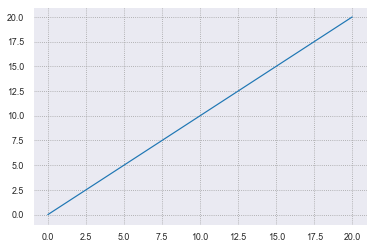

In [75]:
x= np.linspace(0,20, 100)
plt.plot(x, benefit_function(x))

In [34]:
print(array_action)

[[10. 10. 10. ... 10. 10. 10.]
 [10. 10. 10. ... 10. 10. 10.]
 [10. 10. 10. ... 10. 10. 10.]
 [10. 10. 10. ... 10. 10. 10.]
 [10. 10. 10. ... 10. 10. 10.]]


In [9]:
def interact_best_response_one_shot(sum_other_actions : float, exogeneous_emission : float,
                            exogeneous_radiative_forcing : float,
                            benefit_function = polynome(np.zeros(3)),
                            damage_function = polynome(np.zeros(3)),
                            delta = 1.5,
                            smc_player = geophysics(carbon_model, temperature_model)
                            ) -> float:
    
    def interact_utility_one_shot(action : float, sum_other_actions : float, exogeneous_emission : float,
                            exogeneous_radiative_forcing : float) -> float:
        # carbon_model_copy = deepcopy(carbon_model)
        # temperature_model_copy = deepcopy(temperature_model)
        # smc_player = geophysics(carbon_model_copy, temperature_model_copy)
        smc_player_copy = deepcopy(smc_player)
        temp = smc_player_copy.five_years_atmospheric_temp(action + sum_other_actions, exogeneous_emission,
                            exogeneous_radiative_forcing)
        return benefit_function(action) - delta * damage_function(temp) 

    def interact_response(x):
        return -interact_utility_one_shot(x, sum_other_actions, exogeneous_emission, exogeneous_radiative_forcing)

    res = minimize_scalar(interact_response, bounds=action_set, method='bounded', options={'xatol': 1e-05, 'maxiter': 1000, 'disp': 0})
    return res.x

In [10]:

def plot_interact(b1=0, b2=0, b3=0, 
                  d1=0, d2=0, d3=0,
                  delta=0,
                  exogeneous_emission=0, exogeneous_radiative_forcing=0,
                  carbon_model = Carbon_DICE_2016R(), temperature_model = Temp_Discret_Geoffroy()):

    benef_coef = np.array([b1, b2, b3])
    benefit_function = polynome(benef_coef)

    damage_coef = np.array([d1, d2, d3])
    damage_function = polynome(damage_coef)

    smc_player = geophysics(carbon_model, temperature_model)
    responses = [interact_best_response_one_shot(i, exogeneous_emission, exogeneous_radiative_forcing, benefit_function, damage_function, delta, smc_player) for i in sum_other]
    plt.plot(sum_other, responses, label='Best Response')
    plt.legend()
    plt.show()

In [11]:
import ipywidgets
import ipywidgets as widgets


sum_other = np.linspace(0,50,50)

plt.figure(dpi=120)

ipywidgets.interact(plot_interact, 
                    b1=(0,10,0.1), b2=(0,10,0.1), b3=(0,10,0.1), 
                    d1=(0,100,1), d2=(0,100,1), d3=(0,100,1),
                    delta=(0,10,0.1),
                    exogeneous_emission=(0,10,0.1), exogeneous_radiative_forcing=(0,2,0.1),
                    carbon_model = [Carbon_FUND(), Carbon_DICE_2013R(), Carbon_DICE_2016R(), Carbon_JOOS()],
                    temperature_model = widgets.Dropdown(options=[Temp_DICE_2016R(), Temp_Discret_Geoffroy()], description="Temp"))


<Figure size 720x480 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='b1', max=10.0), FloatSlider(value=0.0, description='…

<function __main__.plot_interact(b1=0, b2=0, b3=0, d1=0, d2=0, d3=0, delta=0, exogeneous_emission=0, exogeneous_radiative_forcing=0, carbon_model=<models.geophysic_models.carbon_cycle_models.Carbon_DICE_2016R object at 0x000001197D3F91F0>, temperature_model=<models.geophysic_models.temperature_dynamic_model.Temp_Discret_Geoffroy object at 0x000001197D3F9220>)>

In [47]:
import ipywidgets
import ipywidgets as widgets

sum_other = np.linspace(0,50,50)
b1 = widgets.FloatSlider(min=0, max=10, step=0.1, description='b1')
b2 = widgets.FloatSlider(min=0, max=10, step=0.1, description='b2')
b3 = widgets.FloatSlider(min=0, max=10, step=0.1, description='b3')
d1 = widgets.FloatSlider(min=0, max=100, step=1, description='d1')
d2 = widgets.FloatSlider(min=0, max=100, step=1, description='d2')
d3 = widgets.FloatSlider(min=0, max=100, step=1, description='d3')
delta = widgets.FloatSlider(min=0,max=10, step=0.1, description='delta')
exogeneous_radiative_forcing = widgets.FloatSlider(min=0, max=2, step=0.1, description='exogeneous_radiative_forcing')
exogeneous_emission = widgets.FloatSlider(min=0,max=10, step=0.1, description='exogeneous_emission')

temperature_model = widgets.Dropdown(options=[Temp_DICE_2016R(), Temp_Discret_Geoffroy()], description="temperature_model")
carbon_model = widgets.Dropdown(options=[Carbon_FUND(), Carbon_DICE_2013R(), Carbon_DICE_2016R(), Carbon_JOOS()], description="carbon_model")
ui = widgets.HBox([[b1, b2, b2], [d1, d2, d3], [delta], [exogeneous_emission, exogeneous_radiative_forcing],[carbon_model, temperature_model]])

out = ipywidgets.interactive_output(plot_interact, 
                    {'b1' : b1, 'b2' : b2, 'b3' : b3, 
                    'd1' : d1, 'd2' : d2, 'd3' : d3,
                    'delta' : delta,
                    'exogeneous_emission' : exogeneous_emission, 'exogeneous_radiative_forcing' :exogeneous_radiative_forcing,
                    'carbon_model' : carbon_model,
                    'temperature_model' : temperature_model})

                    
display(out, ui)


TraitError: The 'children' trait of a HBox instance contains an Instance of a TypedTuple which expected a Widget, not the list [FloatSlider(value=0.0, description='b1', max=10.0), FloatSlider(value=0.0, description='b2', max=10.0), FloatSlider(value=0.0, description='b2', max=10.0)].